### Imports

In [1]:
import sys
sys.path.append("..") # root of repo
sys.path.append("../src/")
import os
import numpy as np
import pandas as pd
import pickle as pkl
from collections import Counter, defaultdict
import os.path as osp
from pathlib import Path
from tqdm import tqdm
from PIL import Image
from src.data.datasets import MultiModalHblDataset, ResampledHblDataset
from src.data.labels import LabelDecoder
from src.utils import array2gif, draw_trajectory
import torchvision
import torch
import itertools
import torchvision.transforms as t
import video_transforms as vt
import pytorchvideo.transforms as ptvt
from lit_data import collate_function_builder

from utils import * # debug import

/nfs/home/rhotertj/env/miniconda3/envs/thesis/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/nfs/home/rhotertj/env/miniconda3/envs/thesis/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libjpeg.so.8: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


### Plot class occurences

In [ ]:
df = pd.read_json("dataset_train_sql=16_sr=2_nooverlap.jsonl", lines=True)
df.sample(5)
# TODO np diff over idx with actions at sr=1 gives us frame distance between actions, bar chart for intervals

In [ ]:
f = df.groupby(['class_coarse']).size().plot(kind='pie', y='class_coarse', autopct='%1.2f%%')


### Debugging idx -> Frame index mapping

In [ ]:
sql = 4
hql = sql // 2
rate = 2
sr = sql * rate
hr = hql * rate
kernel = np.ones(sr)

availables = [True, True, True, True, True, True, True, True, True, True, True, True, True, False, False]
pos = np.arange(len(availables))

cv = np.convolve(availables, kernel)
print(f"{cv}")
idxs = np.where(cv == sr)[0] - (sr - 1) # subtract filter length - 1
print("idx for valid sequences:", idxs)

q_idx = 0
f_idx = idxs[q_idx] + hr
sequence = pos[f_idx - hr : f_idx + hr : rate]
print(f"Idx for sequence {q_idx}: {sequence}")

### Visualizing each class

In [24]:
dataset = ResampledHblDataset(
    meta_path="/nfs/home/rhotertj/datasets/hbl/meta3d_val.csv",
    idx_to_frame="/nfs/home/rhotertj/datasets/hbl/resampled/balanced/True/overlap/True/sql_sr/16x2/mode/matches/meta3d_val.jsonl",
    seq_len=16,
    sampling_rate=2,
    load_frames=True,
    label_mapping=LabelDecoder(3)
)

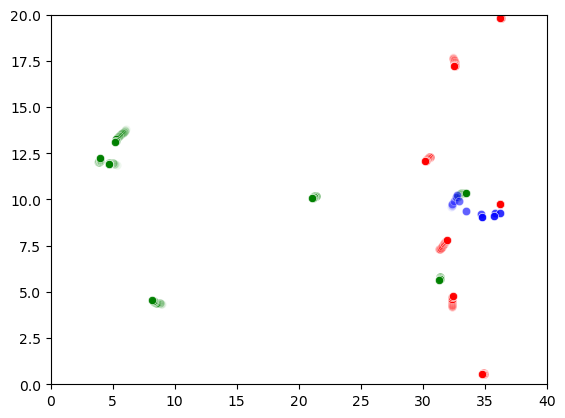

In [25]:
os.makedirs("../img/classes", exist_ok=True)
n_per_class = 3
shots = list(range(0, 9))
passes = ['A', 'B', 'C', 'D', 'E', 'X', 'O']
df = dataset.idx_to_frame_number
for s,p in itertools.product(shots, passes):
    events = df[(df['shot'] == s) & (df['pass'] == p)]
    if len(events) > 0:
        events = events.sample(n_per_class)
        for i, (idx, event) in enumerate(events.iterrows()):
            instance = dataset.__getitem__(idx)
            fname = f"../img/classes/{s}_{p}_{i}"
            array2gif(instance["frames"], fname + ".gif", 10)
            f = draw_trajectory(instance["positions"])
            plt.savefig(fname + ".png")
    

### Calculating Mean and Standard Deviation

In [ ]:
sql = 16
sr = 1
dataset_img = MultiModalHblDataset(
    meta_path="/nfs/home/rhotertj/datasets/hbl/meta3d.csv",
    seq_len=sql,
    sampling_rate=sr,
    load_frames=True
)
print(len(dataset_img))
n = 0
means = np.zeros((len(dataset_img) + sql, 3))
stds = np.zeros((len(dataset_img) + sql, 3))

for i in tqdm(range(0, len(dataset_img), sql)):
    frames = torch.tensor(dataset_img[i]["frames"]) / 255

    for j, frame in enumerate(frames):
        mean, std = frame.mean([1,2]), frame.std([1,2])
        means[i+j] = mean
        stds[i+j] = std

        n+=1
print(n)
print(means.shape)
# Maybe we want to calculate this per match instead of over the whole dataset


In [ ]:
np.save("means.npy", means)
np.save("std.npy", stds)

In [ ]:
print(means.mean(0), stds.mean(0))

### Test plotting

In [ ]:
dataset_img = MultiModalHblDataset(
    meta_path="/nfs/home/rhotertj/datasets/hbl/meta3d.csv",
    seq_len=16,
    sampling_rate=2,
    load_frames=False
)

In [ ]:
instance = dataset_img[11345]

draw_trajectory(instance["positions"])

### Test transforms and augmentation

In [2]:

transforms_jitter = t.Compose([
            vt.FrameSequenceToTensor(),
            vt.TimeFirst(),
            t.ColorJitter(brightness=0.2, hue=.2, contrast=0.2, saturation=0.2),
            vt.ChannelFirst(),
            t.Resize((224,224)),
            ])

transforms_randaugment = t.Compose([
            vt.FrameSequenceToTensor(),
            vt.TimeFirst(),
            t.Resize((224,224)),
            ptvt.RandAugment(num_layers=3, prob=0.5, magnitude=5),
            vt.ChannelFirst(),
            ])

transforms_raw = t.Compose([
            vt.FrameSequenceToTensor(),
            t.Resize((224,224)),
    ])

transforms_full = t.Compose([
            vt.FrameSequenceToTensor(),
            vt.RandomHorizontalFlipVideo(p=0.5),
            vt.TimeFirst(),
            t.ColorJitter(brightness=0.2, hue=.2, contrast=0.2, saturation=0.2),
            ptvt.RandAugment(num_layers=3, prob=0.5, magnitude=5),
            vt.ChannelFirst(),
            t.Resize((224,224)),
            ])
dataset_img = ResampledHblDataset(
                meta_path="/nfs/home/rhotertj/datasets/hbl/meta3d_train.csv",
                idx_to_frame="/nfs/home/rhotertj/datasets/hbl/resampled/balanced/True/overlap/True/sql_sr/16x2/mode/matches/meta3d_train.jsonl",
                label_mapping=LabelDecoder(3),
                load_frames=True,
                seq_len=16,
                sampling_rate=2,
                transforms=transforms_raw
            )

collate_mixvideo = collate_function_builder(epsilon=7, load_frames=True, mix_video=ptvt.MixVideo(num_classes=3, cutmix_alpha=0.8, cutmix_prob=0))
collate_fn = collate_function_builder(epsilon=7, load_frames=True)

In [ ]:
dataset_img.transforms = transforms_randaugment
for i in tqdm(dataset_img):
    pass

In [3]:
raw_instances = []
jitter_instances = []
randaug_instances = []
combined_instances = []
idxs = [13456,23574,98533,64378,22546,324567,243343,9632] #random
for i in range(8):
    dataset_img.transforms = transforms_raw
    instance = dataset_img[idxs[i]]
    raw_instances.append(instance)

    dataset_img.transforms = transforms_jitter
    instance = dataset_img[idxs[i]]
    jitter_instances.append(instance)

    dataset_img.transforms = transforms_randaugment
    instance = dataset_img[idxs[i]]
    randaug_instances.append(instance)

    dataset_img.transforms = transforms_full
    instance = dataset_img[idxs[i]]
    combined_instances.append(instance)

raw_batch = collate_fn(raw_instances)
mix_batch = collate_mixvideo(raw_instances)
jitter_batch = collate_fn(jitter_instances)
randaug_batch = collate_fn(randaug_instances)
combined_batch = collate_mixvideo(combined_instances)

for i in range(8):
    for name, batch in zip(["raw", "mixvideo", "jitter", "randaug", "combined"], [raw_batch, mix_batch, jitter_batch, randaug_batch, combined_batch]):
        frames = batch["frames"][i].mul(255).to(torch.uint8).numpy()
        array2gif(frames, f"../img/transforms/{name}_transforms_{i}.gif", 10)


mixup
